This notebook uses a `SuperTimeDependentSystemWithField` to investigate the dynamics of systems within a super-system. In the following example, individual systems are given different process tensors (by using different coupling strengths). One system can take multiple (or just one) process tensor(s). Alternatively, though  not shown in this example, all systems in the same super-system can take the same process tensor. 

[See the disordered mean field example for an example of multiple systems within a super-system taking a single process tensor.] 

In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt
from oqupy import contractions

In [2]:
oqupy.__version__

'0.3.1'

In [3]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

In [4]:
alpha_one = 0.1 
alpha_two = 0.9 
alpha_three = 0.25
nu_c = 227.9
T = 39.3
omega_0 = 0.0
omega_c = -30.4
Omega = 303.9

kappa = 15.2
Gamma_down = 30.4
Gamma_up = 0.8 * Gamma_down


In [5]:
def H_MF(t, a):
    return 0.5 * omega_0 * sigma_z +\
        0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)

fractions = [0.5, 0.5]
def field_eom(t, states, field):
    sx_exp_list = [np.matmul(sigma_minus, state).trace() for state in states]
    sx_exp_weighted_sum = sum([fraction*sx_exp for fraction, sx_exp in zip(fractions, sx_exp_list)])
    return -(1j*omega_c+kappa)*field - 0.5j*Omega*sx_exp_weighted_sum

In [6]:
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [ lambda t: sigma_minus, lambda t: sigma_plus]

In [7]:
def single_field_eom(t, state, a):
    expect_val = np.matmul(sigma_minus, state).trace()
    return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

system_one = oqupy.TimeDependentSystemWithField(
        H_MF,
        single_field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

system_two = oqupy.TimeDependentSystemWithField(
        H_MF,
        single_field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

In [8]:
correlations_one = oqupy.PowerLawSD(alpha=alpha_one,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)
correlations_two = oqupy.PowerLawSD(alpha=alpha_two,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

correlations_three = oqupy.PowerLawSD(alpha=alpha_three,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

bath_one = oqupy.Bath(0.5 * sigma_z, correlations_one)
bath_two = oqupy.Bath(0.5 * sigma_z, correlations_two)
bath_three = oqupy.Bath(0.5 * sigma_z, correlations_three)

In [9]:
initial_field = np.sqrt(0.05)               # Note n_0 = <a^dagger a>(0) = 0.05
initial_state_one = np.array([[0,0],[0,1]]) # spin down
initial_state_two = np.array([[0,0],[0,1]]) # spin down

In [10]:
tempo_parameters = oqupy.TempoParameters(dt=3.2e-3, dkmax=20, epsrel=10**(-5))
start_time = 0.0
end_time = 1.3

process_tensor_one = oqupy.pt_tempo_compute(bath=bath_one,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_two = oqupy.pt_tempo_compute(bath=bath_two,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_three = oqupy.pt_tempo_compute(bath=bath_three,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:09
Elapsed time: 9.8s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:25
Elapsed time: 25.4s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:11
Elapsed time: 11.7s


In [11]:
initial_state_list = [initial_state_one , initial_state_two]
control_list = [oqupy.Control(system_one.dimension), oqupy.Control(system_two.dimension)]
super_system = oqupy.SuperTimeDependentSystemWithField([system_one, system_two], field_eom=field_eom)

super_system_dynamics_with_field = contractions.compute_dynamics_with_field_multiple_systems(super_system, initial_field=initial_field, 
                                                                                        initial_state_list=initial_state_list, 
                                                                                        start_time=start_time,
                                                                                        process_tensor_list = [[process_tensor_one, process_tensor_three], process_tensor_two]
                                                                                        )

--> Compute dynamics with field:
100.0%  406 of  406 [########################################] 00:00:42
Elapsed time: 42.7s


In [12]:
t_list = []
n_list = []
tsz_list = []
sz_list = []

for dynamics in super_system_dynamics_with_field.dynamics_list:
    t_list.append(dynamics.times)
    n_list.append(np.abs(dynamics.fields)**2)
    t, s_z = dynamics.expectations(0.5*sigma_z, real=True)
    tsz_list.append(t)
    sz_list.append(s_z)

We investigate the spin expectation over time of the systems in the super-system.

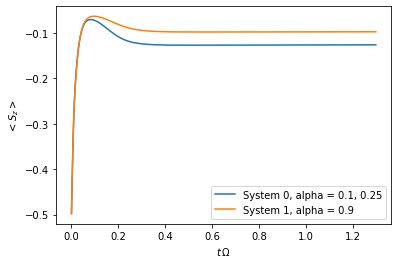

In [13]:
alphas = [alpha_one, alpha_two]
for i in range(len(tsz_list)):
    if i == 0:
        label = f"System {i}, alpha = {alphas[i]}, {alpha_three}"
    else:
        label = f"System {i}, alpha = {alphas[i]}"
    plt.plot(tsz_list[i], sz_list[i], label=label)
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.legend(loc='best')

Next, we investigate the changes in scaled photon number over time for both systems in the super-system. It is expected that both systems in the super-system should produce the same plot. 

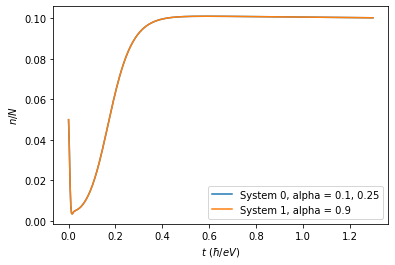

In [14]:
for i in range(len(n_list)):
    if i == 0:
        label = f"System {i}, alpha = {alphas[i]}, {alpha_three}"
    else:
        label = f"System {i}, alpha = {alphas[i]}"
    plt.plot(t_list[i], n_list[i], label=label)
    
plt.xlabel(r'$t$ ($\hbar/eV$)')
plt.ylabel(r'$n/N$')
plt.legend(loc='best') 